Шаг 1. Скрэпинг страницы Wkipedia, на которой расположен список дорам с гиперссылками, переходя по которым можно узнать жанры, список актеров, исполнивших главные роли, количество эпизодов и канал, на котором дорама транслировалась.

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd


class WikiSpider(scrapy.Spider):
    name = 'wikispider'
    # Сайт, с которого беру данные
    start_urls = [
        'https://en.wikipedia.org/wiki/List_of_Korean_dramas'
    ]
    def parse(self, response):
        # Перебор всех элементов списка на странице
        for movie in response.css('.mw-parser-output ul li'):
            title_year = movie.xpath('string(.)').get()
            # Разделение названия и года
            if '(' in title_year and ')' in title_year:
                year = title_year.split('(')[1].split(')')[0]
                title = title_year.split('(')[0].strip()
            else:
                title = title_year
                year = None
            # Получение ссылки на подробную о конкретной дораме
            link = movie.css('a::attr(href)').get() 
            if link is not None:
                yield response.follow(url = response.urljoin(link), callback=self.parse_movie, cb_kwargs={'title': title, 'year': year})
    
    # Получение данных об жанрах, главных актёрах, количестве эпизодов и канале, на котором дорама транслировалась
    def parse_movie(self, response, title, year):
        genres_selector = 'th:contains("Genre") + td a::text, th:contains("Genre") + td::text, th:contains("Genre") + td span::text, th:contains("Genre") + td li::text, th:contains("Genre") + td div::text, th:contains("Genre") + td br::text'
        genres = response.css(genres_selector).getall()
        
        network_selector = 'th:contains("Network") + td a::text'
        network = response.css(network_selector).get()
        
        episodes_selector = 'th:contains("No. of episodes") + td a::text, th:contains("No. of episodes") + td::text, th:contains("No. of episodes") + td span::text, th:contains("No. of episodes") + td li::text, th:contains("No. of episodes") + td div::text, th:contains("No. of episodes") + td br::text'
        episodes = response.css(episodes_selector).getall()
        
        actors_selector = 'th:contains("Starring") + td a::text, th:contains("Starring") + td::text, th:contains("Starring") + td span::text, th:contains("Starring") + td li::text, th:contains("Starring") + td div::text, th:contains("Starring") + td br::text'
        actors = response.css(actors_selector).getall() 
        
        genres = [genre.strip() for genre in genres if genre.strip()]
        actors = [actor.strip() for actor in actors if actor.strip()]
             
        yield {
            'title': title,
            'year': year,
            'actors':actors,
            'genres': genres,
            'network': network,
            'episodes': episodes
        }

process = CrawlerProcess({
    'FEEDS': {
        'output_17.csv': {
            'format': 'csv'
        }
    },
    'LOG_LEVEL': 'WARNING'
})
process.crawl(WikiSpider)
process.start()

C:\Users\a-riz\anaconda3\Lib\site-packages\scrapy\utils\_compression.py:15: ScrapyDeprecationWarning: You have brotlipy installed, and Scrapy will use it, but Scrapy support for brotlipy is deprecated and will stop working in a future version of Scrapy. brotlipy itself is deprecated, it has been superseded by brotlicffi (not currently supported by Scrapy). Please, uninstall brotlipy and install brotli instead. brotlipy has the same import name as brotli, so keeping both installed is strongly discouraged.
  warn(
2024-06-08 19:40:45 [py.warnings] WARNING: C:\Users\a-riz\anaconda3\Lib\site-packages\scrapy\utils\request.py:254: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of 

Шаг 2. Обработка полученных данных

Скрэпинг страниц Wikipedia достаточно проблематичен в силу того, что там нет какого-то единого формата кода для информации, то есть, например, для скрэпинга жанров разных дорам могут быть нужны различные селекторы. В процессе скрэпинга копировались лишние символы, данные и т.д. После их удаления образовывались последовательности из двух и более запятых, их я тоже удалила. Также я привела к типу int года и количество эпизодов. 

In [2]:
import pandas as pd

df = pd.read_csv('output_17.csv')

# Очищение столбца с жанрами
df_filtered = df[df['genres'].notna()]
df_filtered = df_filtered[~df_filtered['genres'].str.contains(r'\[|\]', regex=True)]
df_filtered = df_filtered[~df_filtered['genres'].str.contains('<')]
df_filtered['genres'] = df_filtered['genres'].str.replace(',{2,}', ',', regex=True)

# Очищение столбца с годами выпуска
df_filtered = df_filtered[df_filtered['year'].notna()]
df_filtered = df_filtered[df_filtered['year'].str.match(r'^\d{4}$')]
df_filtered['year'] = df_filtered['year'].astype(int)

# Очищение столбца с количеством эпизодов
df_filtered = df_filtered[df_filtered['episodes'].notna()]
df_filtered = df_filtered[df_filtered['episodes'].str.match(r'^\d+$')]
df_filtered['episodes'] = df_filtered['episodes'].astype(int)

# Очищение столбца с главными актёрами
df_filtered['actors'] = df_filtered['actors'].str.replace('\[|\]|\)|\)', '', regex=True)
df_filtered['actors'] = df_filtered['actors'].str.replace(',{2,}', ',', regex=True)
df_filtered['actors'] = df_filtered['actors'].str.replace(' ,', ',', regex=True)
df_filtered['actors'] = df_filtered['actors'].str.strip(',')
df_filtered['actors'] = df_filtered['actors'].fillna('').astype(str)

df_filtered.to_csv('filtered_dramas.csv', index=False)
df = pd.read_csv('filtered_dramas.csv')


                                                 title  year  \
0                                A Tale of Two Sisters  2013   
1                                     12 Years Promise  2014   
2                                     12 Signs of Love  2012   
3                                             18 Again  2020   
4                                         A Poem a Day  2018   
5                                           A New Leaf  2014   
6                                              Iljimae  2008   
7                                       Gangnam Beauty  2018   
8                              L.U.C.A.: The Beginning  2021   
9                                     Korean Peninsula  2012   
10                                        Line Romance  2014   
11                                   Love on a Rooftop  2015   
12                                  My Lovely Sam Soon  2005   
13                                      My Lovely Girl  2014   
14                                      

Шаг 3. Bar plot для количества дорам в каждом жанре.

Если вы хотите понять, стоит ли вам смотреть дорамы, то в первую очередь следует посмотреть на то, какие жанры наиболее распространены среди них. Поскольку на Wikipedia предложено огромное количество жанров, о многих из которых я даже не слышала, было решено оставить только те жанры, в которых снято более 7 дорам. Итак, как мы видим, наиболее популярными жанрами являются: романтика, драма и комедия, поэтому дорамы больше подходят для любителей этих жанров.

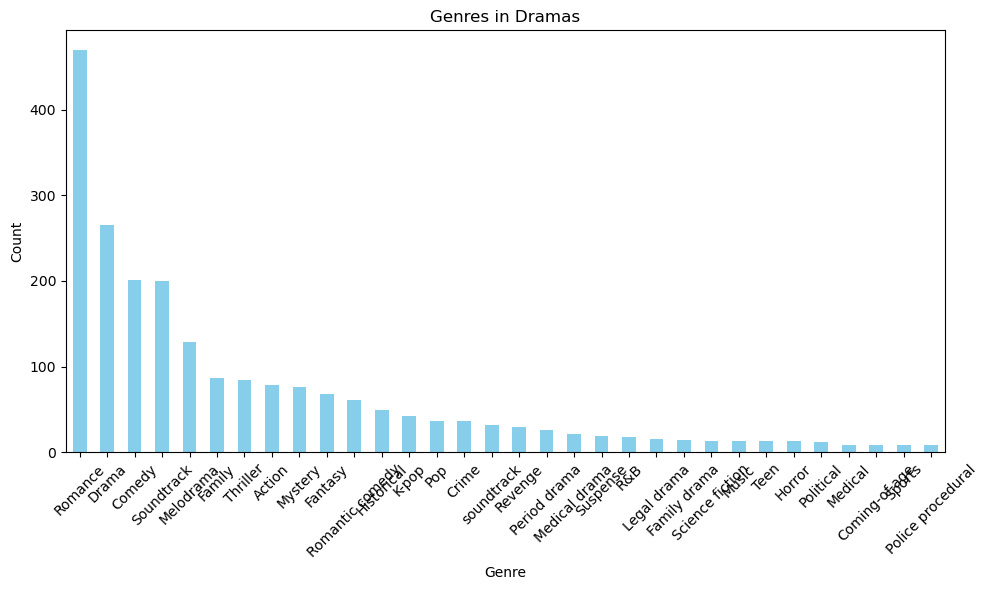

In [3]:
import matplotlib.pyplot as plt

# Разделение жанров по строкам датафрейма
df['genres'] = df['genres'].str.split(',')
genres_exploded = df.explode('genres')

genre_counts = genres_exploded['genres'].value_counts()

# Оставляем только те жанры, которые упоминаются больше 7 раз
filtered_genre_counts = genre_counts[genre_counts >7]

# Создание графика
plt.figure(figsize = (10,6))
filtered_genre_counts.plot(kind = 'bar',color = 'skyblue')
plt.title('Genres in Dramas')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()



Шаг 4. Граф для актеров дорам.

Используя библиотеку Networkx, я построила граф, позволяющий определить, какие актеры снимались друг с другом и как часто. Если актеры соединены ребром, то они совместно участвовали хотя бы в одной дораме. Более того, цвет ребра позволяет определить, в скольких дорамах они снимались вместе. Справа от графа приведена шкала, наглядно показывающая, как определить случаи.

Благодаря этому графику, вы сможете узнать, не снимались ли ваши любимые актеры вместе.


2024-06-08 19:41:17 [py.warnings] WARNING: C:\Users\a-riz\AppData\Local\Temp\ipykernel_4800\3965985783.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Количество Совместных Упоминаний')



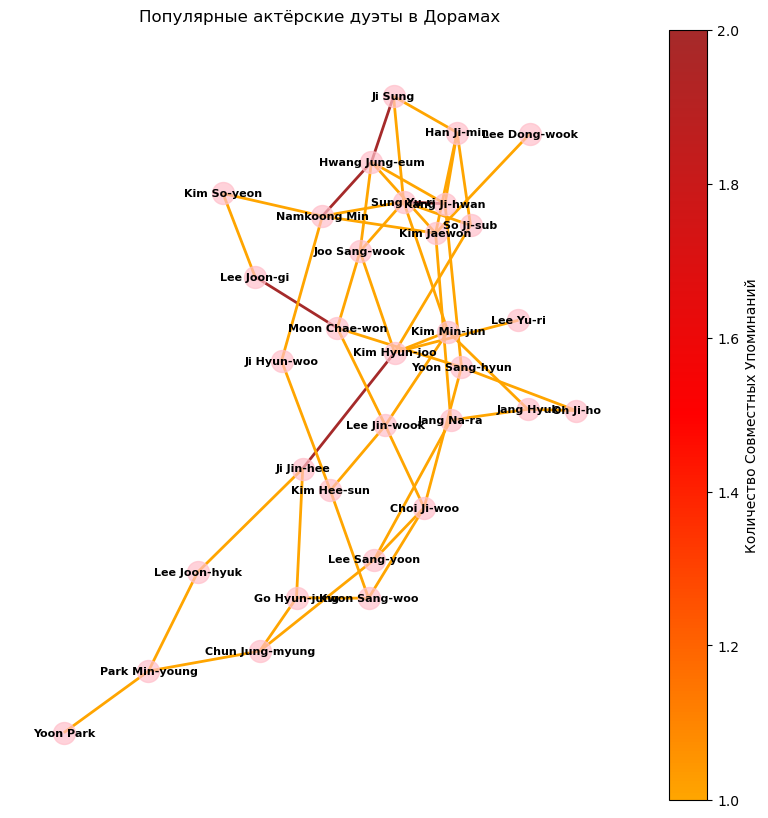

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
from collections import Counter
from itertools import combinations

df = pd.read_csv('filtered_dramas.csv')

actors_list = df['actors'].dropna().tolist()

# Подсчёт количества дорам для каждого актёра
actor_drama_count = Counter()
for actors in actors_list:
    for actor in actors.split(','):
        actor_drama_count[actor.strip()] += 1

# Я решила оставить только актёров, которые снялись в более, чем восьми дорамах, как наиболее востребованных
actors_more_than_8_dramas = {actor for actor, count in actor_drama_count.items() if count > 8}

# Подсчёт уникальных пар актёров, которые работали вместе и снялись в более чем 8 дорамах
pair_counter = Counter()
for actors in actors_list:
    actors_list_filtered = [actor.strip() for actor in actors.split(',') if actor.strip() in actors_more_than_8_dramas]
    if len(actors_list_filtered) > 1:
        for combo in combinations(actors_list_filtered, 2):
            pair_counter[tuple(sorted(combo))] += 1

popular_pairs = {pair: count for pair, count in pair_counter.items()}

# Создание графа
G = nx.Graph()
for pair, count in popular_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

# Определение цветов ребер на основе весов
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)

# Нормализация весов для получения значений от 0 до 1. Здесь возникала проблема, состоявшая в том, что минимальный и максимальный веса могли совпадать. В таких случаях я ставила нормализованным весом середину отрезка, то есть 0.5
if max_weight != min_weight:
    normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]
else:
    normalized_weights = [0.5 for weight in edge_weights]

# Создание цветовой шкалы
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['orange', 'red', 'brown'])

# Генерация цветов, согласно правилу:чем чаще упонимается пара, тем более темное ребро; реже - тем светлее
edge_colors = [cmap(weight) for weight in normalized_weights]

# Определение позиции узлов
pos = nx.spring_layout(G)

# Создание графа
plt.figure(figsize=(10, 10))
edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nodes = nx.draw_networkx_nodes(G, pos, node_size=250, node_color='pink', alpha=0.7)
labels = nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Добавление цветовой шкалы
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm._A = []
plt.colorbar(sm, label='Количество Совместных Упоминаний')

plt.title("Популярные актёрские дуэты в Дорамах")
plt.axis('off') 
plt.show()



Шаг 6. Выполнения статистического теста для проверки гипотезы о том, количества эпизодов в дорамах разных жанров различаются

Я использовала scipy, чтобы провести анализ дисперсии ANOVA, используемый для сравнения средних значений трех или более групп. Я пришла к выводу, что различия в количестве эпизодов в дорамах разных жанров являются статистически значимыми. В таком случае стоит понять, в каких жанрах больше всего эпизодов, а в каких меньше всего, что и будет моим следующим шагом.

In [5]:
import pandas as pd
from scipy import stats
import numpy as np

# Разделение жанров по строкам датафрейма
df['genres'] = df['genres'].str.split(',')
df_exploded = df.explode('genres')

# Создание словаря, в котором ключи - это жанры, а значения - списки из количеств эпизодов
genre_episodes = df_exploded.groupby('genres')['episodes'].apply(list).to_dict()

# Преобразование в массивы
episodes_list = [np.array(count) for count in genre_episodes.values() if len(count) > 0]


# Выполнение ANOVA
if len(episodes_list) > 1:
    f_value, p_value = stats.f_oneway(*genre_episodes.values())

    print(f'F-значение: {f_value}, p-значение: {p_value}')

    # Интерпретация результатов
    if p_value < 0.05:
        print('Есть статистически значимые различия в количестве эпизодов по разным жанрам.')
    else:
        print('Нет статистически значимых различий в количестве эпизодов по разным жанрам.')
else:
    print('Недостаточно данных для проведения ANOVA.')

F-значение: 3.940571776444822, p-значение: 5.807852790812237e-46
Есть статистически значимые различия в количестве эпизодов по разным жанрам.


Шаг 7. Тепловая карта совместного распределения жанров и количества эпизодов

На мой взгляд, самым наглядным способом показать взаимосвязь количество эпизодов и жанров дорам является тепловая карта, которую можно поистроить с использованием библиотеки seaborn.
Выбранные мною диапозоны довольно специфичны, однако я выбирала их исходя из своего опыта. Страндартное колчиество серий в дорамах 12, 16, 20, 25, поэтому я сделала такие диапозоны, что все они лежат в различных полуинтервалах. Также я оставила только те жанры, в которых снято более 7 дорам, как наиболее популярные

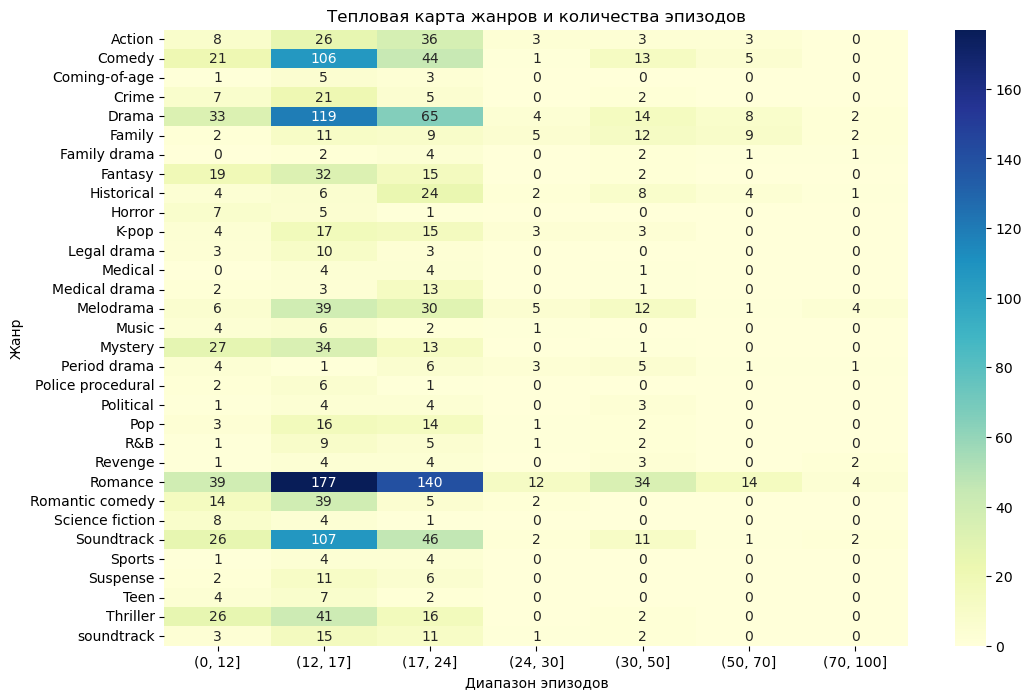

In [6]:
import seaborn as sns
data = []

# Оставляем только те жанры, которые упоминаются более семи раз
for genre, episodes in genre_episodes.items():
    if len(episodes)>7:
        for episode_count in episodes:
            data.append({'genre': genre, 'episodes': episode_count})
df_ge = pd.DataFrame(data)


# Преобразуем количество эпизодов в категориальные диапазоны
df_ge['episodes_range'] = pd.cut(df_ge['episodes'], bins=[0, 12, 17, 24, 30, 50, 70, 100])

# Создаем сводную таблицу для тепловой карты
pivot_table = df_ge.pivot_table(index='genre', columns='episodes_range', aggfunc='size', fill_value=0)

# Создание тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Тепловая карта жанров и количества эпизодов')
plt.ylabel('Жанр')
plt.xlabel('Диапазон эпизодов')
plt.show()

Шаг 8. Линейная регрессия количества эпизодов на год выпуска дорамы.

Интересно также проследить взаимосвязь между годом выпуска дорамы и количеством эпизодов. Для этого я использовала LinearRegression. На графике вы можете наблюдать ScatterPlot и линию регрессии. Как мы видим, наблюдается небольшой тренд на снижение количества эпизодов. 

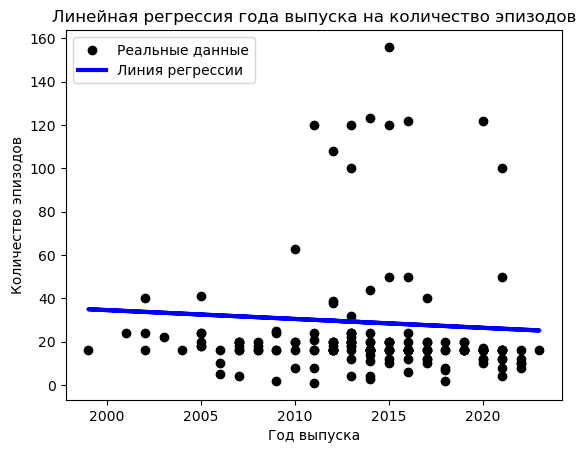

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


X = df[['year']]  # Независимая переменная
y = df['episodes']  # Зависимая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание количества эпизодов
y_pred = model.predict(X_test)

# Создание графика
plt.scatter(X_test, y_test, color='black', label='Реальные данные')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Линия регрессии')
plt.title('Линейная регрессия года выпуска на количество эпизодов')
plt.xlabel('Год выпуска')
plt.ylabel('Количество эпизодов')
plt.legend()
plt.show()

In [8]:
pwd


'C:\\Users\\a-riz'